<a href="https://colab.research.google.com/github/KOreshOK9922/bridge_frafity-bot/blob/main/%D1%81%D1%82%D1%80%D1%83%D0%BA%D1%82%D1%83%D1%80%D0%B0_%D1%81_%D0%BA%D0%BE%D1%80%D1%80%D0%B5%D0%BB%D1%8F%D1%86%D0%B8%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import pearsonr

# Константы
Q_VALUES = [50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 500.0]
Q_NV_VALUES = [40, 50, 60]

CARGO_TYPES = [
    {"name": "Каменный уголь", "a_p": 1.224, "a_o": 1.066, "b": 0.660},
    {"name": "Нефть", "a_p": 1.260, "a_o": 1.160, "b": 0.658},
    {"name": "Руда", "a_p": 1.293, "a_o": 1.188, "b": 0.657},
    {"name": "Черные металлы", "a_p": 1.249, "a_o": 1.090, "b": 0.652},
    {"name": "Лесные", "a_p": 1.232, "a_o": 1.076, "b": 0.676},
    {"name": "Минеральные и строительные материалы", "a_p": 1.393, "a_o": 1.225, "b": 0.653},
    {"name": "Химические и минеральные удобрения", "a_p": 1.289, "a_o": 1.128, "b": 0.642},
    {"name": "Хлебные", "a_p": 1.420, "a_o": 1.241, "b": 0.662},
    {"name": "Прочие", "a_p": 1.320, "a_o": 1.139, "b": 0.701}
]

CHANNEL_STRUCTURES = {
    "1-канал": {"channels": 1},
    "2-канала (10/90)": {"channels": 2, "distribution": [0.1, 0.9]},
    "2-канала (30/70)": {"channels": 2, "distribution": [0.3, 0.7]},
    "2-канала (50/50)": {"channels": 2, "distribution": [0.5, 0.5]},
    "3-канала (10/20/70)": {"channels": 3, "distribution": [0.1, 0.2, 0.7]},
    "3-канала (20/30/50)": {"channels": 3, "distribution": [0.2, 0.3, 0.5]},
    "3-канала (33.3)": {"channels": 3, "distribution": [1/3, 1/3, 1/3]}
}

def generate_channel_data(q, distribution, days=5):
    """Генерация данных для каналов на основе нормального распределения"""
    data = {}
    for i, dist in enumerate(distribution):
        mean = q * dist
        std_dev = mean * 0.1  # Стандартное отклонение = 10% от среднего
        data[f"Канал {i+1}"] = np.random.normal(mean, std_dev, days)
    return pd.DataFrame(data)

def calculate_sigma(cargo, m, distribution=None):
    """Вычисляет значения сигма для заданных параметров"""
    if distribution is None:
        return {
            'sigma_p': cargo["a_p"] * (m ** cargo["b"]),
            'sigma_o': cargo["a_o"] * (m ** cargo["b"]),
        }

    channel_sigmas_p = [cargo["a_p"] * ((m * dist) ** cargo["b"]) for dist in distribution]
    channel_sigmas_o = [cargo["a_o"] * ((m * dist) ** cargo["b"]) for dist in distribution]

    return {
        'sigma_p': np.sqrt(np.sum(np.array(channel_sigmas_p)**2)),
        'sigma_o': np.sqrt(np.sum(np.array(channel_sigmas_o)**2))
    }

def calculate_sigma_with_correlation(cargo, m, distribution, correlations):
    """Вычисляет сигма с учетом корреляций между каналами"""
    sigmas_p = cargo["a_p"] * ((m * np.array(distribution)) ** cargo["b"])
    sigmas_o = cargo["a_o"] * ((m * np.array(distribution)) ** cargo["b"])

    # Расчет дисперсии с учетом корреляций
    sigma_p_combined = np.sqrt(np.sum(sigmas_p**2) + 2 * np.sum([correlations[i, j] * sigmas_p[i] * sigmas_p[j] for i in range(len(sigmas_p)) for j in range(i+1, len(sigmas_p))]))
    sigma_o_combined = np.sqrt(np.sum(sigmas_o**2) + 2 * np.sum([correlations[i, j] * sigmas_o[i] * sigmas_o[j] for i in range(len(sigmas_o)) for j in range(i+1, len(sigmas_o))]))

    return {
        'sigma_p': sigma_p_combined,
        'sigma_o': sigma_o_combined
    }

def calculate_H(sigma):
    """Вычисляет значение H по формуле H=log[σ * √(2πe)]"""
    return np.log(sigma * np.sqrt(2 * np.pi * np.e))

def calculate_cargo_deviations_combined():
    """Основная функция расчета отклонений для всех грузов с учетом влияния каналов одновременно"""
    results = []
    for cargo in CARGO_TYPES:
        for q in Q_VALUES:
            for q_nv in Q_NV_VALUES:
                m = q / q_nv
                for structure_name, structure in CHANNEL_STRUCTURES.items():
                    distribution = structure.get("distribution", None)
                    if distribution:
                        # Генерация данных для каналов
                        data = generate_channel_data(q, distribution)
                        correlations = data.corr().values  # Расчет корреляций

                        # Расчет сигма с корреляцией и без
                        sigmas_with_corr = calculate_sigma_with_correlation(cargo, m, distribution, correlations)
                        sigmas_without_corr = calculate_sigma(cargo, m, distribution)
                    else:
                        sigmas_with_corr = calculate_sigma(cargo, m)
                        sigmas_without_corr = calculate_sigma(cargo, m)

                    # Расчет H
                    H_p_with_corr = calculate_H(sigmas_with_corr['sigma_p'])
                    H_o_with_corr = calculate_H(sigmas_with_corr['sigma_o'])
                    H_p_without_corr = calculate_H(sigmas_without_corr['sigma_p'])
                    H_o_without_corr = calculate_H(sigmas_without_corr['sigma_o'])

                    # Сохранение результатов
                    results.append({
                        "Груз": cargo["name"],
                        "Суточный грузопоток q (т/сутки)": q,
                        "Технорма грузоподъемности q_nv (т)": q_nv,
                        "m (q/q_nv)": round(m, 2),
                        "Структура каналов": structure_name,
                        "Отклонение для прибытия σ_p (без корреляции)": round(sigmas_without_corr['sigma_p'], 6),
                        "Отклонение для отправления σ_o (без корреляции)": round(sigmas_without_corr['sigma_o'], 6),
                        "H для прибытия (без корреляции)": round(H_p_without_corr, 6),
                        "H для отправления (без корреляции)": round(H_o_without_corr, 6),
                        "Отклонение для прибытия σ_p (с корреляцией)": round(sigmas_with_corr['sigma_p'], 6),
                        "Отклонение для отправления σ_o (с корреляцией)": round(sigmas_with_corr['sigma_o'], 6),
                        "H для прибытия (с корреляцией)": round(H_p_with_corr, 6),
                        "H для отправления (с корреляцией)": round(H_o_with_corr, 6),
                        "Корреляции между каналами": correlations.tolist() if distribution else None
                    })
    return pd.DataFrame(results)

def create_subplot(ax, title, xlabel, ylabel):
    """Настройка параметров подграфика"""
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle='--', alpha=0.7)

def plot_cargo_analysis(df, cargo, pdf):
    """Создание графиков для отдельного груза"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
    plt.suptitle(f"Анализ отклонений для {cargo['name']}", fontsize=16)

    create_subplot(ax1, "Зависимость отклонения прибытия σ_p от m", "m (q/q_nv)", "σ_p")
    create_subplot(ax2, "Зависимость отклонения отправления σ_o от m", "m (q/q_nv)", "σ_o")

    color_palette = sns.color_palette("husl", len(CHANNEL_STRUCTURES))

    for (structure_name, color) in zip(CHANNEL_STRUCTURES.keys(), color_palette):
        cargo_data = df[(df['Груз'] == cargo['name']) &
                         (df['Структура каналов'] == structure_name)]

        for ax, column in [(ax1, 'Отклонение для прибытия σ_p (с корреляцией)'),
                           (ax2, 'Отклонение для отправления σ_o (с корреляцией)')]:
            ax.plot(cargo_data['m (q/q_nv)'], cargo_data[column],
                   label=structure_name, color=color, marker='o', linestyle='-')
            ax.legend()

    plt.tight_layout()
    pdf.savefig()
    plt.close()

def plot_H_analysis(df, cargo, pdf):
    """Создание графиков зависимости H от σ для отдельного груза"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
    plt.suptitle(f"Анализ зависимости H от σ для {cargo['name']}", fontsize=16)

    create_subplot(ax1, "Зависимость H для прибытия от σ_p", "σ_p", "H")
    create_subplot(ax2, "Зависимость H для отправления от σ_o", "σ_o", "H")

    color_palette = sns.color_palette("husl", len(CHANNEL_STRUCTURES))

    for (structure_name, color) in zip(CHANNEL_STRUCTURES.keys(), color_palette):
        cargo_data = df[(df['Груз'] == cargo['name']) &
                         (df['Структура каналов'] == structure_name)]

        ax1.plot(cargo_data['Отклонение для прибытия σ_p (с корреляцией)'], cargo_data['H для прибытия (с корреляцией)'],
                 label=structure_name, color=color, marker='o', linestyle='-')

        ax2.plot(cargo_data['Отклонение для отправления σ_o (с корреляцией)'], cargo_data['H для отправления (с корреляцией)'],
                 label=structure_name, color=color, marker='o', linestyle='-')

    ax1.legend()
    ax2.legend()

    plt.tight_layout()
    pdf.savefig()
    plt.close()

def plot_deviations():
    """Создание PDF с графиками отклонений"""
    df = calculate_cargo_deviations_combined()

    with PdfPages('cargo_deviations_combined_analysis.pdf') as pdf:
        # Графики для каждого типа груза
        for cargo in CARGO_TYPES:
            plot_cargo_analysis(df, cargo, pdf)

        # Сводный анализ
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15))
        plt.suptitle("Сводный анализ отклонений для всех грузов", fontsize=16)

        create_subplot(ax1, "Зависимость отклонения прибытия σ_p от m", "m (q/q_nv)", "σ_p")
        create_subplot(ax2, "Зависимость отклонения отправления σ_o от m", "m (q/q_nv)", "σ_o")

        color_palette = sns.color_palette("husl", len(CARGO_TYPES))
        for cargo, color in zip(CARGO_TYPES, color_palette):
            cargo_data = df[df['Груз'] == cargo['name']]

            for ax, column in [(ax1, 'Отклонение для прибытия σ_p (с корреляцией)'),
                               (ax2, 'Отклонение для отправления σ_o (с корреляцией)')]:
                ax.plot(cargo_data['m (q/q_nv)'], cargo_data[column],
                        label=cargo['name'], color=color, marker='o', linestyle='--')
                ax.legend()

        plt.tight_layout()
        pdf.savefig()
        plt.close()

    print("Графики сохранены в файл cargo_deviations_combined_analysis.pdf")

def plot_H_deviations():
    """Создание PDF с графиками H"""
    df = calculate_cargo_deviations_combined()

    with PdfPages('cargo_H_deviations_combined_analysis.pdf') as pdf:
        # Графики для каждого типа груза
        for cargo in CARGO_TYPES:
            plot_H_analysis(df, cargo, pdf)

    print("Графики H сохранены в файл cargo_H_deviations_combined_analysis.pdf")

def main():
    """Основная функция программы"""
    # Выполнение расчетов и сохранение в Excel
    df = calculate_cargo_deviations_combined()
    excel_path = 'cargo_deviations_combined.xlsx'
    df.to_excel(excel_path, index=False, sheet_name='Расчеты')
    print(f"Результаты сохранены в файл {excel_path}")

    # Построение графиков отклонений
    plot_deviations()

    # Построение графиков H
    plot_H_deviations()

if __name__ == "__main__":
    main()



Результаты сохранены в файл cargo_deviations_combined.xlsx
Графики сохранены в файл cargo_deviations_combined_analysis.pdf
Графики H сохранены в файл cargo_H_deviations_combined_analysis.pdf


## НИЖЕ КОД СЛИШКОМ ВЕЛИК _НЕ ХВАТАЕТ ПАМЯТИ

Результаты сохранены в файл cargo_deviations_combined.xlsx


KeyboardInterrupt: 

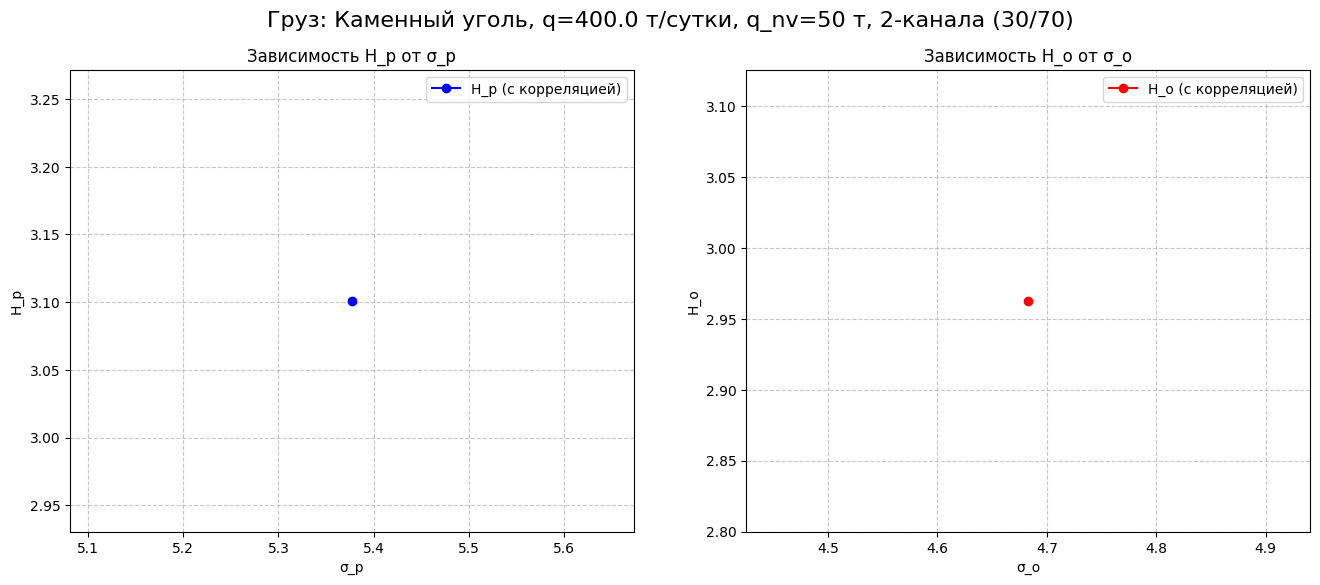

In [ ]:

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import pearsonr

# Константы
Q_VALUES = [50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 500.0]
Q_NV_VALUES = [40, 50, 60]

CARGO_TYPES = [
    {"name": "Каменный уголь", "a_p": 1.224, "a_o": 1.066, "b": 0.660},
    {"name": "Нефть", "a_p": 1.260, "a_o": 1.160, "b": 0.658},
    {"name": "Руда", "a_p": 1.293, "a_o": 1.188, "b": 0.657},
    {"name": "Черные металлы", "a_p": 1.249, "a_o": 1.090, "b": 0.652},
    {"name": "Лесные", "a_p": 1.232, "a_o": 1.076, "b": 0.676},
    {"name": "Минеральные и строительные материалы", "a_p": 1.393, "a_o": 1.225, "b": 0.653},
    {"name": "Химические и минеральные удобрения", "a_p": 1.289, "a_o": 1.128, "b": 0.642},
    {"name": "Хлебные", "a_p": 1.420, "a_o": 1.241, "b": 0.662},
    {"name": "Прочие", "a_p": 1.320, "a_o": 1.139, "b": 0.701}
]

CHANNEL_STRUCTURES = {
    "1-канал": {"channels": 1},
    "2-канала (10/90)": {"channels": 2, "distribution": [0.1, 0.9]},
    "2-канала (30/70)": {"channels": 2, "distribution": [0.3, 0.7]},
    "2-канала (50/50)": {"channels": 2, "distribution": [0.5, 0.5]},
    "3-канала (10/20/70)": {"channels": 3, "distribution": [0.1, 0.2, 0.7]},
    "3-канала (20/30/50)": {"channels": 3, "distribution": [0.2, 0.3, 0.5]},
    "3-канала (33.3)": {"channels": 3, "distribution": [1/3, 1/3, 1/3]}
}

def generate_channel_data(q, distribution, days=5):
    """Генерация данных для каналов на основе нормального распределения"""
    data = {}
    for i, dist in enumerate(distribution):
        mean = q * dist
        std_dev = mean * 0.1  # Стандартное отклонение = 10% от среднего
        data[f"Канал {i+1}"] = np.random.normal(mean, std_dev, days)
    return pd.DataFrame(data)

def calculate_sigma(cargo, m, distribution=None):
    """Вычисляет значения сигма для заданных параметров"""
    if distribution is None:
        return {
            'sigma_p': cargo["a_p"] * (m ** cargo["b"]),
            'sigma_o': cargo["a_o"] * (m ** cargo["b"]),
        }

    channel_sigmas_p = [cargo["a_p"] * ((m * dist) ** cargo["b"]) for dist in distribution]
    channel_sigmas_o = [cargo["a_o"] * ((m * dist) ** cargo["b"]) for dist in distribution]

    return {
        'sigma_p': np.sqrt(np.sum(np.array(channel_sigmas_p)**2)),
        'sigma_o': np.sqrt(np.sum(np.array(channel_sigmas_o)**2))
    }

def calculate_sigma_with_correlation(cargo, m, distribution, correlations):
    """Вычисляет сигма с учетом корреляций между каналами"""
    sigmas_p = cargo["a_p"] * ((m * np.array(distribution)) ** cargo["b"])
    sigmas_o = cargo["a_o"] * ((m * np.array(distribution)) ** cargo["b"])

    # Расчет дисперсии с учетом корреляций
    sigma_p_combined = np.sqrt(np.sum(sigmas_p**2) + 2 * np.sum([correlations[i, j] * sigmas_p[i] * sigmas_p[j] for i in range(len(sigmas_p)) for j in range(i+1, len(sigmas_p))]))
    sigma_o_combined = np.sqrt(np.sum(sigmas_o**2) + 2 * np.sum([correlations[i, j] * sigmas_o[i] * sigmas_o[j] for i in range(len(sigmas_o)) for j in range(i+1, len(sigmas_o))]))

    return {
        'sigma_p': sigma_p_combined,
        'sigma_o': sigma_o_combined
    }

def calculate_H(sigma):
    """Вычисляет значение H по формуле H=log[σ * √(2πe)]"""
    return np.log(sigma * np.sqrt(2 * np.pi * np.e))

def calculate_cargo_deviations_combined():
    """Основная функция расчета отклонений для всех грузов с учетом влияния каналов одновременно"""
    results = []
    for cargo in CARGO_TYPES:
        for q in Q_VALUES:
            for q_nv in Q_NV_VALUES:
                m = q / q_nv
                for structure_name, structure in CHANNEL_STRUCTURES.items():
                    distribution = structure.get("distribution", None)
                    if distribution:
                        # Генерация данных для каналов
                        data = generate_channel_data(q, distribution)
                        correlations = data.corr().values  # Расчет корреляций

                        # Расчет сигма с корреляцией и без
                        sigmas_with_corr = calculate_sigma_with_correlation(cargo, m, distribution, correlations)
                        sigmas_without_corr = calculate_sigma(cargo, m, distribution)
                    else:
                        sigmas_with_corr = calculate_sigma(cargo, m)
                        sigmas_without_corr = calculate_sigma(cargo, m)

                    # Расчет H
                    H_p_with_corr = calculate_H(sigmas_with_corr['sigma_p'])
                    H_o_with_corr = calculate_H(sigmas_with_corr['sigma_o'])
                    H_p_without_corr = calculate_H(sigmas_without_corr['sigma_p'])
                    H_o_without_corr = calculate_H(sigmas_without_corr['sigma_o'])

                    # Сохранение результатов
                    results.append({
                        "Груз": cargo["name"],
                        "Суточный грузопоток q (т/сутки)": q,
                        "Технорма грузоподъемности q_nv (т)": q_nv,
                        "m (q/q_nv)": round(m, 2),
                        "Структура каналов": structure_name,
                        "Отклонение для прибытия σ_p (без корреляции)": round(sigmas_without_corr['sigma_p'], 6),
                        "Отклонение для отправления σ_o (без корреляции)": round(sigmas_without_corr['sigma_o'], 6),
                        "H для прибытия (без корреляции)": round(H_p_without_corr, 6),
                        "H для отправления (без корреляции)": round(H_o_without_corr, 6),
                        "Отклонение для прибытия σ_p (с корреляцией)": round(sigmas_with_corr['sigma_p'], 6),
                        "Отклонение для отправления σ_o (с корреляцией)": round(sigmas_with_corr['sigma_o'], 6),
                        "H для прибытия (с корреляцией)": round(H_p_with_corr, 6),
                        "H для отправления (с корреляцией)": round(H_o_with_corr, 6),
                        "Корреляции между каналами": correlations.tolist() if distribution else None
                    })
    return pd.DataFrame(results)

def create_individual_tables(df):
    """Создает отдельные таблицы для каждого груза, тоннажа и структуры каналов"""
    individual_tables = []

    for cargo in CARGO_TYPES:
        for q in Q_VALUES:
            for q_nv in Q_NV_VALUES:
                for structure_name in CHANNEL_STRUCTURES.keys():
                    # Фильтрация данных
                    filtered_data = df[
                        (df['Груз'] == cargo['name']) &
                        (df['Суточный грузопоток q (т/сутки)'] == q) &
                        (df['Технорма грузоподъемности q_nv (т)'] == q_nv) &
                        (df['Структура каналов'] == structure_name)
                    ]
                    if not filtered_data.empty:
                        individual_tables.append({
                            "Груз": cargo['name'],
                            "q": q,
                            "q_nv": q_nv,
                            "Структура каналов": structure_name,
                            "Данные": filtered_data
                        })

    return individual_tables

def plot_individual_graphs(individual_tables, pdf):
    """Создает отдельные графики для каждой таблицы"""
    for table in individual_tables:
        cargo_name = table["Груз"]
        q = table["q"]
        q_nv = table["q_nv"]
        structure_name = table["Структура каналов"]
        data = table["Данные"]

        # График зависимости σ_p и σ_o от m
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        plt.suptitle(f"Груз: {cargo_name}, q={q} т/сутки, q_nv={q_nv} т, {structure_name}", fontsize=16)

        create_subplot(axes[0], "Зависимость σ_p от m", "m (q/q_nv)", "σ_p")
        create_subplot(axes[1], "Зависимость σ_o от m", "m (q/q_nv)", "σ_o")

        axes[0].plot(data['m (q/q_nv)'], data['Отклонение для прибытия σ_p (с корреляцией)'],
                    label="σ_p (с корреляцией)", color='blue', marker='o', linestyle='-')
        axes[1].plot(data['m (q/q_nv)'], data['Отклонение для отправления σ_o (с корреляцией)'],
                    label="σ_o (с корреляцией)", color='red', marker='o', linestyle='-')

        for ax in axes:
            ax.legend(fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)

        plt.tight_layout()
        pdf.savefig()
        plt.close()

        # График зависимости H_p и H_o от σ
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        plt.suptitle(f"Груз: {cargo_name}, q={q} т/сутки, q_nv={q_nv} т, {structure_name}", fontsize=16)

        create_subplot(axes[0], "Зависимость H_p от σ_p", "σ_p", "H_p")
        create_subplot(axes[1], "Зависимость H_o от σ_o", "σ_o", "H_o")

        axes[0].plot(data['Отклонение для прибытия σ_p (с корреляцией)'], data['H для прибытия (с корреляцией)'],
                    label="H_p (с корреляцией)", color='blue', marker='o', linestyle='-')
        axes[1].plot(data['Отклонение для отправления σ_o (с корреляцией)'], data['H для отправления (с корреляцией)'],
                    label="H_o (с корреляцией)", color='red', marker='o', linestyle='-')

        for ax in axes:
            ax.legend(fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)

        plt.tight_layout()
        pdf.savefig()
        plt.close()

def create_subplot(ax, title, xlabel, ylabel):
    """Настройка параметров подграфика"""
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

def plot_deviations():
    """Создание PDF с графиками отклонений"""
    df = calculate_cargo_deviations_combined()

    # Создание отдельных таблиц для каждого груза, тоннажа и структуры каналов
    individual_tables = create_individual_tables(df)

    # Построение графиков на основе отдельных таблиц
    with PdfPages('cargo_deviations_individual_analysis.pdf') as pdf:
        plot_individual_graphs(individual_tables, pdf)

    print("Графики сохранены в файл cargo_deviations_individual_analysis.pdf")

def main():
    """Основная функция программы"""
    # Выполнение расчетов и сохранение в Excel
    df = calculate_cargo_deviations_combined()
    excel_path = 'cargo_deviations_combined.xlsx'
    df.to_excel(excel_path, index=False, sheet_name='Расчеты')
    print(f"Результаты сохранены в файл {excel_path}")

    # Построение графиков отклонений
    plot_deviations()

if __name__ == "__main__":
    main()



## КОД С ЗАПРОСОМ ВИДА ГРУЗА

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

# Константы
Q_VALUES = [50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 500.0]
Q_NV_VALUES = [40, 50, 60]

CARGO_TYPES = [
    {"name": "Каменный уголь", "a_p": 1.224, "a_o": 1.066, "b": 0.660},
    {"name": "Нефть", "a_p": 1.260, "a_o": 1.160, "b": 0.658},
    {"name": "Руда", "a_p": 1.293, "a_o": 1.188, "b": 0.657},
]

CHANNEL_STRUCTURES = {
    "1 канал": {"channels": 1},
    "2 канала (10/90)": {"channels": 2, "distribution": [0.1, 0.9]},
    "2 канала (30/70)": {"channels": 2, "distribution": [0.3, 0.7]},
}

def calculate_sigma(cargo, m, distribution=None):
    """Вычисляет значения сигма для заданных параметров"""
    if distribution is None:
        return {
            'sigma_p': cargo["a_p"] * (m ** cargo["b"]),
            'sigma_o': cargo["a_o"] * (m ** cargo["b"]),
        }

    channel_sigmas_p = [cargo["a_p"] * ((m * dist) ** cargo["b"]) for dist in distribution]
    channel_sigmas_o = [cargo["a_o"] * ((m * dist) ** cargo["b"]) for dist in distribution]

    return {
        'sigma_p': np.mean(channel_sigmas_p),
        'sigma_o': np.mean(channel_sigmas_o)
    }

def calculate_cargo_deviations():
    """Основная функция расчета отклонений"""
    results = []
    for cargo in CARGO_TYPES:
        for q in Q_VALUES:
            for q_nv in Q_NV_VALUES:
                m = q / q_nv
                for structure_name, structure in CHANNEL_STRUCTURES.items():
                    distribution = structure.get("distribution")
                    sigmas = calculate_sigma(cargo, m, distribution)

                    results.append({
                        "Груз": cargo["name"],
                        "Суточный грузопоток q (т/сутки)": q,
                        "Технорма грузоподъемности q_nv (т)": q_nv,
                        "m (q/q_nv)": round(m, 2),
                        "Структура каналов": structure_name,
                        "Отклонение для прибытия σ_p": round(sigmas['sigma_p'], 6),
                        "Отклонение для отправления σ_o": round(sigmas['sigma_o'], 6)
                    })
    return pd.DataFrame(results)

def create_subplot(ax, title, xlabel, ylabel):
    """Настройка параметров подграфика"""
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle='--', alpha=0.7)

def plot_cargo_analysis(df, cargo, pdf):
    """Создание графиков для отдельного груза"""
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    plt.suptitle(f"Анализ отклонений для {cargo['name']}", fontsize=16)

    create_subplot(axes[0], "Зависимость отклонения прибытия σ_p от m", "m (q/q_nv)", "σ_p")
    create_subplot(axes[1], "Зависимость отклонения отправления σ_o от m", "m (q/q_nv)", "σ_o")

    color_palette = sns.color_palette("husl", len(CHANNEL_STRUCTURES))

    for structure_name, color in zip(CHANNEL_STRUCTURES.keys(), color_palette):
        cargo_data = df[(df['Груз'] == cargo['name']) &
                         (df['Структура каналов'] == structure_name)]

        # Плавные линии вместо маркеров
        axes[0].plot(cargo_data['m (q/q_nv)'], cargo_data['Отклонение для прибытия σ_p'],
                     label=structure_name, color=color, linestyle='-', linewidth=2)
        axes[1].plot(cargo_data['m (q/q_nv)'], cargo_data['Отклонение для отправления σ_o'],
                     label=structure_name, color=color, linestyle='-', linewidth=2)

    axes[0].legend()
    axes[1].legend()
    plt.tight_layout()
    pdf.savefig()
    plt.close()

def plot_deviations():
    """Создание PDF с графиками"""
    df = calculate_cargo_deviations()

    with PdfPages('cargo_deviations_analysis7.pdf') as pdf:
        # Графики для каждого типа груза
        for cargo in CARGO_TYPES:
            plot_cargo_analysis(df, cargo, pdf)

    print("Графики сохранены в файл cargo_deviations_analysis7.pdf")

def main():
    """Основная функция программы"""
    plot_deviations()

if __name__ == "__main__":
    main()


Графики сохранены в файл cargo_deviations_analysis7.pdf


08.01.2025 радость))

In [ ]:
"""# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Константы
Q_VALUES = [50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 500.0]  # Возможные значения суточного грузопотока (q)
Q_NV_VALUES = [40, 50, 60]  # Возможные значения технормы грузоподъемности (q_nv)

# Типы грузов и их параметры
CARGO_TYPES = [
    {"name": "Каменный уголь", "a_p": 1.224, "a_o": 1.066, "b": 0.660},
    {"name": "Нефь", "a_p": 1.260, "a_o": 1.160, "b": 0.658},
    {"name": "Руда", "a_p": 1.293, "a_o": 1.188, "b": 0.657},
    {"name": "Черные металлы", "a_p": 1.249, "a_o": 1.090, "b": 0.652},
    {"name": "Лесные", "a_p": 1.232, "a_o": 1.076, "b": 0.676},
    {"name": "Минеральные и строительные материалы", "a_p": 1.393, "a_o": 1.225, "b": 0.653},
    {"name": "Химические и минеральные удобрения", "a_p": 1.289, "a_o": 1.128, "b": 0.642},
    {"name": "Хлебные", "a_p": 1.420, "a_o": 1.241, "b": 0.662},
    {"name": "Прочие", "a_p": 1.320, "a_o": 1.139, "b": 0.701}
]

# Структуры каналов и их распределения
CHANNEL_STRUCTURES = {
    "1 канал": {"channels": 1},
    "2 канала (10/90)": {"channels": 2, "distribution": [0.1, 0.9]},
    "2 канала (30/70)": {"channels": 2, "distribution": [0.3, 0.7]},
    "2 канала (50/50)": {"channels": 2, "distribution": [0.5, 0.5]},
    "3 канала (10/20/70)": {"channels": 3, "distribution": [0.1, 0.2, 0.7]},
    "3 канала (20/30/50)": {"channels": 3, "distribution": [0.2, 0.3, 0.5]},
    "3 канала (33.3)": {"channels": 3, "distribution": [1/3, 1/3, 1/3]}
}

# Функция для генерации данных для каналов
def generate_channel_data(q, distribution, days=5):
    """Генерация данных для каналов на основе нормального распределения."""
    data = {}
    for i, dist in enumerate(distribution):
        mean = q * dist
        std_dev = mean * 0.1
        data[f"Канал {i+1}"] = np.random.normal(mean, std_dev, days)
    return pd.DataFrame(data)

# Функция для расчета сигма без учета корреляций
def calculate_sigma(cargo, m, distribution=None):
    """Вычисляет значения сигма для заданных параметров."""
    if distribution is None:
        return {
            'sigma_p': cargo["a_p"] * (m ** cargo["b"]),
            'sigma_o': cargo["a_o"] * (m ** cargo["b"]),
        }

    channel_sigmas_p = [cargo["a_p"] * ((m * dist) ** cargo["b"]) for dist in distribution]
    channel_sigmas_o = [cargo["a_o"] * ((m * dist) ** cargo["b"]) for dist in distribution]

    return {
        'sigma_p': np.sqrt(np.sum(np.array(channel_sigmas_p)**2)),
        'sigma_o': np.sqrt(np.sum(np.array(channel_sigmas_o)**2))
    }

# Функция для расчета сигма с учетом корреляций
def calculate_sigma_with_correlation(cargo, m, distribution, correlations):
    """Вычисляет сигма с учетом корреляций между каналами."""
    sigmas_p = cargo["a_p"] * ((m * np.array(distribution)) ** cargo["b"])
    sigmas_o = cargo["a_o"] * ((m * np.array(distribution)) ** cargo["b"])

    sigma_p_combined = np.sqrt(np.sum(sigmas_p**2) + 2 * np.sum([correlations[i, j] * sigmas_p[i] * sigmas_p[j] for i in range(len(sigmas_p)) for j in range(i+1, len(sigmas_p))]))
    sigma_o_combined = np.sqrt(np.sum(sigmas_o**2) + 2 * np.sum([correlations[i, j] * sigmas_o[i] * sigmas_o[j] for i in range(len(sigmas_o)) for j in range(i+1, len(sigmas_o))]))

    return {
        'sigma_p': sigma_p_combined,
        'sigma_o': sigma_o_combined
    }

# Функция для расчета значения H
def calculate_H(sigma):
    """Вычисляет значение H по формуле H=log[σ * √(2πe)]."""
    return np.log(sigma * np.sqrt(2 * np.pi * np.e))

# Основная функция для расчета отклонений
def calculate_cargo_deviations():
    """Основная функция расчета отклонений."""
    results = []
    for cargo in CARGO_TYPES:
        for q in Q_VALUES:
            for q_nv in Q_NV_VALUES:
                m = q / q_nv
                for structure_name, structure in CHANNEL_STRUCTURES.items():
                    distribution = structure.get("distribution")
                    if distribution:
                        data = generate_channel_data(q, distribution)
                        correlations = data.corr().values
                        sigmas_with_corr = calculate_sigma_with_correlation(cargo, m, distribution, correlations)
                    else:
                        sigmas_with_corr = calculate_sigma(cargo, m)

                    sigmas_without_corr = calculate_sigma(cargo, m, distribution) if distribution else calculate_sigma(cargo, m)

                    results.append({
                        "Груз": cargo["name"],
                        "Суточный грузопоток q (т/сути)": q,
                        "Технорма грузоподъемности q_nv (т)": q_nv,
                        "m (q/q_nv)": round(m, 2),
                        "Структура каналов": structure_name,
                        "Отклонение для прибытия σ_p (без корреляции)": round(sigmas_without_corr['sigma_p'], 6),
                        "Отклонение для отправления σ_o (без корреляции)": round(sigmas_without_corr['sigma_o'], 6),
                        "H для прибытия (без корреляции)": round(calculate_H(sigmas_without_corr['sigma_p']), 6),
                        "H для отправления (без корреляции)": round(calculate_H(sigmas_without_corr['sigma_o']), 6),
                        "Отклонение для прибытия σ_p (с корреляцией)": round(sigmas_with_corr['sigma_p'], 6),
                        "Отклонение для отправления σ_o (с корреляцией)": round(sigmas_with_corr['sigma_o'], 6),
                        "H для прибытия (с корреляцией)": round(calculate_H(sigmas_with_corr['sigma_p']), 6),
                        "H для отправления (с корреляцией)": round(calculate_H(sigmas_with_corr['sigma_o']), 6),
                        "Корреляции между каналами": correlations.tolist() if distribution else None
                    })
    return pd.DataFrame(results)

# Функция для настройки подграфика
def create_subplot(ax, title, xlabel, ylabel):
    """Настройка параметров подграфика"""
    ax.set_title(title, fontsize=10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle='--', alpha=0.7)

# Функция для построения фигуры с 6 строками и 6 столбцами
def plot_cargo_analysis(df, cargo, pdf):
    """Создание фигуры с графиками для конкретного груза."""
    fig, axes = plt.subplots(6, 6, figsize=(30, 30))  # Создаем фигуру с 6 строками и 6 столбцами
    plt.suptitle(f"Груз: {cargo}", fontsize=16)  # Общий заголовок фигуры

    # Пройдем по каждой технорме
    for i, q_nv in enumerate(Q_NV_VALUES):
        # Фильтрация данных для конкретного q_nv
        filtered_data = df[(df['Технорма грузоподъемности q_nv (т)'] == q_nv)]

        # Пройдем по каждой структуре каналов
        for j, structure_name in enumerate(CHANNEL_STRUCTURES.keys()):
            # Фильтрация данных для конкретной структуры каналов
            structure_data = filtered_data[filtered_data['Структура каналов'] == structure_name]

            # Сортируем данные по суточному грузопотоку (q)
            structure_data = structure_data.sort_values(by="Суточный грузопоток q (т/сути)")

            # Получаем количество каналов
            channels = CHANNEL_STRUCTURES[structure_name]["channels"]

            # График σ_p от q
            ax = axes[j, i]  # Выбираем подграфик в j строке и i столбце
            create_subplot(ax, f"σ_p от q (q_nv = {q_nv}, {structure_name})", "Суточный грузопоток q (т/сути)", "σ_p")

            # Линии без корреляции
            ax.plot(structure_data['Суточный грузопоток q (т/сути)'], structure_data['Отклонение для прибытия σ_p (без корреляции)'],
                    label=f'{structure_name} (без корреляции)', linestyle='-', color='blue')

            # Линии с корреляцией (если каналов больше одного)
            if channels > 1:
                ax.plot(structure_data['Суточный грузопоток q (т/сути)'], structure_data['Отклонение для прибытия σ_p (с корреляцией)'],
                        label=f'{structure_name} (с корреляцией)', linestyle='--', color='red')
            ax.legend()

            # График H_p от σ_p
            ax = axes[j + 3, i]  # Выбираем подграфик в (j + 3) строке и i столбце
            create_subplot(ax, f"H_p от σ_p (q_nv = {q_nv}, {structure_name})", "σ_p", "H_p")

            # Линии без корреляции
            ax.plot(structure_data['Отклонение для прибытия σ_p (без корреляции)'], structure_data['H для прибытия (без корреляции)'],
                    label=f'{structure_name} (без корреляции)', linestyle='-', color='blue')

            # Линии с корреляцией (если каналов больше одного)
            if channels > 1:
                ax.plot(structure_data['Отклонение для прибытия σ_p (с корреляцией)'], structure_data['H для прибытия (с корреляцией)'],
                        label=f'{structure_name} (с корреляцией)', linestyle='--', color='red')
            ax.legend()

            # График σ_o от q
            ax = axes[j, i + 3]  # Выбираем подграфик в j строке и (i + 3) столбце
            create_subplot(ax, f"σ_o от q (q_nv = {q_nv}, {structure_name})", "Суточный грузопоток q (т/сути)", "σ_o")

            # Линии без корреляции
            ax.plot(structure_data['Суточный грузопоток q (т/сути)'], structure_data['Отклонение для отправления σ_o (без корреляции)'],
                    label=f'{structure_name} (без корреляции)', linestyle='-', color='blue')

            # Линии с корреляцией (если каналов больше одного)
            if channels > 1:
                ax.plot(structure_data['Суточный грузопоток q (т/сути)'], structure_data['Отклонение для отправления σ_o (с корреляцией)'],
                        label=f'{structure_name} (с корреляцией)', linestyle='--', color='red')
            ax.legend()

            # График H_o от σ_o
            ax = axes[j + 3, i + 3]  # Выбираем подграфик в (j + 3) строке и (i + 3) столбце
            create_subplot(ax, f"H_o от σ_o (q_nv = {q_nv}, {structure_name})", "σ_o", "H_o")

            # Линии без корреляции
            ax.plot(structure_data['Отклонение для отправления σ_o (без корреляции)'], structure_data['H для отправления (без корреляции)'],
                    label=f'{structureнию} (без корреляции)', linestyle='-', color='blue')

            # Линии с корреляцией (если каналов больше одного)
            if channels > 1:
                ax.plot(structure_data['Отклонение для отправления σ_o (с корреляцией)'], structure_data['H для отправления (с корреляцией)'],
                        label=f'{structure_name} (с корреляцией)', linestyle='--', color='red')
            ax.legend()

    plt.tight_layout()  # Улучшаем компоновку
    pdf.savefig(fig)  # Сохраняем график в PDF
    plt.close()  # Закрываем фигуру

# Функция для создания PDF с графиками для всех грузов
def plot_all_cargo_deviations():
    """Создание PDF с графиками для всех грузов."""
    df = calculate_cargo_deviations()  # Вычисляем отклонения

    # Проверка всех столбцов в DataFrame
    print("Столбцы в DataFrame:", df.columns.tolist())  # Выводим все столбцы для проверки

    with PdfPages('cargo_analysis.pdf') as pdf:  # Открываем PDF для записи
        for cargo in CARGO_TYPES:  # Проходим по каждому типу груза
            plot_cargo_analysis(df, cargo["name"], pdf)  # Строим графики для каждого груза

    print("Графики сохранены в файл cargo_analysis.pdf")  # Сообщение об успешном завершении

# Основная функция программы
def main():
    """Основная функция программы."""
    plot_all_cargo_deviations()  # Запуск построения и сохранения графиков

# Запуск программы
if __name__ == "__main__":
    main()




ДРУГОЙ ПОДХОД (по отдельности)

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import zipfile
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter

# Параметры для расчета
q_values = np.arange(50, 550, 50)
q_nv_values = [40, 50, 60]
goods = {
    "каменный уголь": {"a_p": 1.224, "a_o": 1.066, "b": 0.660},
    "нефть": {"a_p": 1.260, "a_o": 1.160, "b": 0.658},
    "руда": {"a_p": 1.293, "a_o": 1.188, "b": 0.657},
    "черные металлы": {"a_p": 1.249, "a_o": 1.090, "b": 0.652},
    "лесные": {"a_p": 1.232, "a_o": 1.076, "b": 0.676},
    "минеральные и строительные материалы": {"a_p": 1.393, "a_o": 1.225, "b": 0.653},
    "химические и минеральные удобрения": {"a_p": 1.289, "a_o": 1.128, "b": 0.642},
    "хлебные": {"a_p": 1.420, "a_o": 1.241, "b": 0.662},
    "прочие": {"a_p": 1.320, "a_o": 1.139, "b": 0.701}
}

# Структуры каналов
channel_structures = {
    "one_channel": {},
    "two_channels": [
        {"shares": [0.1, 0.9], "label": "10_90"},
        {"shares": [0.3, 0.7], "label": "30_70"},
        {"shares": [0.5, 0.5], "label": "50_50"}
    ],
    "three_channels": [
        {"shares": [0.1, 0.2, 0.7], "label": "10_20_70"},
        {"shares": [0.2, 0.3, 0.5], "label": "20_30_50"},
        {"shares": [1/3, 1/3, 1/3], "label": "33_33_33"}
    ]
}

# Функции для расчета
def calculate_sigma_one_channel(q, q_nv, a_p, a_o, b):
    m = q / q_nv
    sigma_p = a_p * (m ** b)
    sigma_o = a_o * (m ** b)
    return sigma_p, sigma_o

def calculate_sigma_two_channels(shares, q, q_nv, a_p, a_o, b, correlation=0):
    q1 = shares[0] * q
    q2 = shares[1] * q
    m1 = q1 / q_nv
    m2 = q2 / q_nv
    sigma_p1 = a_p * (m1 ** b)
    sigma_p2 = a_p * (m2 ** b)
    sigma_o1 = a_o * (m1 ** b)
    sigma_o2 = a_o * (m2 ** b)

    sigma_p_combined = np.sqrt(sigma_p1**2 + sigma_p2**2 + 2 * correlation * sigma_p1 * sigma_p2)
    sigma_o_combined = np.sqrt(sigma_o1**2 + sigma_o2**2 + 2 * correlation * sigma_o1 * sigma_o2)

    return sigma_p_combined, sigma_o_combined

def calculate_sigma_three_channels(shares, q, q_nv, a_p, a_o, b, correlation=0):
    q1 = shares[0] * q
    q2 = shares[1] * q
    q3 = shares[2] * q
    m1 = q1 / q_nv
    m2 = q2 / q_nv
    m3 = q3 / q_nv
    sigma_p1 = a_p * (m1 ** b)
    sigma_p2 = a_p * (m2 ** b)
    sigma_p3 = a_p * (m3 ** b)
    sigma_o1 = a_o * (m1 ** b)
    sigma_o2 = a_o * (m2 ** b)
    sigma_o3 = a_o * (m3 ** b)

    sigma_p_combined = np.sqrt(sigma_p1**2 + sigma_p2**2 + sigma_p3**2 +
                               2 * correlation * (sigma_p1 * sigma_p2 + sigma_p1 * sigma_p3 + sigma_p2 * sigma_p3))
    sigma_o_combined = np.sqrt(sigma_o1**2 + sigma_o2**2 + sigma_o3**2 +
                               2 * correlation * (sigma_o1 * sigma_o2 + sigma_o1 * sigma_o3 + sigma_o2 * sigma_o3))

    return sigma_p_combined, sigma_o_combined

def calculate_H(sigma):
    H = np.log(sigma * np.sqrt(2 * np.pi * np.e))
    return H

def save_to_excel(results):
    with pd.ExcelWriter('results.xlsx') as writer:
        for goods_name, goods_data in results.items():
            for q_nv in q_nv_values:
                dfs = []
                for q, q_data in goods_data.items():
                    df_q = pd.DataFrame({
                        'q': q,
                        'q_nv': q_nv
                    }, index=[0])

                    for channel_type in ['one_channel', 'two_channels', 'three_channels']:
                        if channel_type == 'one_channel':
                            df_q['σ_p'] = q_data[q_nv]['one_channel']['σ_p']
                            df_q['H_p'] = q_data[q_nv]['one_channel']['H_p']
                            df_q['σ_o'] = q_data[q_nv]['one_channel']['σ_o']
                            df_q['H_o'] = q_data[q_nv]['one_channel']['H_o']
                        else:
                            for label, data in q_data[q_nv][channel_type].items():
                                df_q[f'σ_p_{channel_type}_{label}'] = data['no_corr']['σ_p']
                                df_q[f'H_p_{channel_type}_{label}'] = data['no_corr']['H_p']
                                df_q[f'σ_o_{channel_type}_{label}'] = data['no_corr']['σ_o']
                                df_q[f'H_o_{channel_type}_{label}'] = data['no_corr']['H_o']
                                df_q[f'σ_p_{channel_type}_{label}_corr'] = data['corr']['σ_p']
                                df_q[f'H_p_{channel_type}_{label}_corr'] = data['corr']['H_p']
                                df_q[f'σ_o_{channel_type}_{label}_corr'] = data['corr']['σ_o']
                                df_q[f'H_o_{channel_type}_{label}_corr'] = data['corr']['H_o']

                    dfs.append(df_q)
                df_goods_qnv = pd.concat(dfs, ignore_index=True)
                df_goods_qnv.to_excel(writer, sheet_name=f'{goods_name}_qnv{q_nv}')

def create_plots(results):
    sigma_filenames = []
    h_filenames = []

    for goods_name, goods_data in results.items():
        plt.figure(figsize=(18, 20))
        plt.subplots_adjust(hspace=0.5, wspace=0.4)

        ## Графики для прибытия
        for q_nv_index, q_nv in enumerate(q_nv_values):
            # Подграфик для σ прибытия
            plt.subplot(4, 3, q_nv_index + 1)  # Строка 1 для σ прибытия
            for q in q_values:
                # Один канал
                σ_o = goods_data[q][q_nv]['one_channel']['σ_o']
                plt.plot(q, σ_o, 'ro-', markersize=5)  # Один канал

                # Два канала
                for label, data in goods_data[q][q_nv]['two_channels'].items():
                    plt.plot(q, data['no_corr']['σ_o'], 'r--', markersize=5, label=f'2 канала {label} σ_o (без)' if q == 50 else "")
                    plt.plot(q, data['corr']['σ_o'], 'r:', markersize=5, label=f'2 канала {label} σ_o (с)' if q == 50 else "")

                # Три канала
                for label, data in goods_data[q][q_nv]['three_channels'].items():
                    plt.plot(q, data['no_corr']['σ_o'], 'g-.', markersize=5, label=f'3 канала {label} σ_o (без)' if q == 50 else "")
                    plt.plot(q, data['corr']['σ_o'], 'g:', markersize=5, label=f'3 канала {label} σ_o (с)' if q == 50 else "")

            plt.xlabel('Суточный грузопоток (т)', fontsize=10)
            plt.ylabel('Значения σ_o', fontsize=10)
            plt.title(f'σ прибытия для q_nv={q_nv}', fontsize=12)
            plt.grid()

        # Графики для H прибытия
        for q_nv_index, q_nv in enumerate(q_nv_values):
            plt.subplot(4, 3, q_nv_index + 4)  # Строка 2 для H прибытия
            for q in q_values:
                # Один канал
                H_o = goods_data[q][q_nv]['one_channel']['H_o']
                plt.plot(q, H_o, 'ro-', markersize=5)  # Один канал

                # Два канала
                for label, data in goods_data[q][q_nv]['two_channels'].items():
                    plt.plot(q, calculate_H(data['no_corr']['σ_o']), 'r--', markersize=5, label=f'2 канала {label} H_o (без)' if q == 50 else "")
                    plt.plot(q, calculate_H(data['corr']['σ_o']), 'r:', markersize=5, label=f'2 канала {label} H_o (с)' if q == 50 else "")

                # Три канала
                for label, data in goods_data[q][q_nv]['three_channels'].items():
                    plt.plot(q, calculate_H(data['no_corr']['σ_o']), 'g-.', markersize=5, label=f'3 канала {label} H_o (без)' if q == 50 else "")
                    plt.plot(q, calculate_H(data['corr']['σ_o']), 'g:', markersize=5, label=f'3 канала {label} H_o (с)' if q == 50 else "")

            plt.xlabel('Суточный грузопоток (т)', fontsize=10)
            plt.ylabel('Значения H_o', fontsize=10)
            plt.title(f'H прибытия для q_nv={q_nv}', fontsize=12)
            plt.grid()

        # Графики для отправления (то же самое)
        for q_nv_index, q_nv in enumerate(q_nv_values):
            # Подграфик для σ отправления
            plt.subplot(4, 3, q_nv_index + 7)  # Строка 3 для σ отправления
            for q in q_values:
                # Один канал
                σ_p = goods_data[q][q_nv]['one_channel']['σ_p']
                plt.plot(q, σ_p, 'bo-', markersize=5)  # Один канал

                # Два канала
                for label, data in goods_data[q][q_nv]['two_channels'].items():
                    plt.plot(q, data['no_corr']['σ_p'], 'b--', markersize=5, label=f'2 канала {label} σ_p (без)' if q == 50 else "")
                    plt.plot(q, data['corr']['σ_p'], 'b:', markersize=5, label=f'2 канала {label} σ_p (с)' if q == 50 else "")

                # Три канала
                for label, data in goods_data[q][q_nv]['three_channels'].items():
                    plt.plot(q, data['no_corr']['σ_p'], 'g-.', markersize=5, label=f'3 канала {label} σ_p (без)' if q == 50 else "")
                    plt.plot(q, data['corr']['σ_p'], 'g:', markersize=5, label=f'3 канала {label} σ_p (с)' if q == 50 else "")

            plt.xlabel('Суточный грузопоток (т)', fontsize=10)
            plt.ylabel('Значения σ_p', fontsize=10)
            plt.title(f'σ отправления для q_nv={q_nv}', fontsize=12)
            plt.grid()

        # Графики для H отправления
        for q_nv_index, q_nv in enumerate(q_nv_values):
            plt.subplot(4, 3, q_nv_index + 10)  # Строка 4 для H отправления
            for q in q_values:
                # Один канал
                H_p = goods_data[q][q_nv]['one_channel']['H_p']
                plt.plot(q, H_p, 'bo-', markersize=5)  # Один канал

                # Два канала
                for label, data in goods_data[q][q_nv]['two_channels'].items():
                    plt.plot(q, calculate_H(data['no_corr']['σ_p']), 'b--', markersize=5, label=f'2 канала {label} H_p (без)' if q == 50 else "")
                    plt.plot(q, calculate_H(data['corr']['σ_p']), 'b:', markersize=5, label=f'2 канала {label} H_p (с)' if q == 50 else "")

                # Три канала
                for label, data in goods_data[q][q_nv]['three_channels'].items():
                    plt.plot(q, calculate_H(data['no_corr']['σ_p']), 'g-.', markersize=5, label=f'3 канала {label} H_p (без)' if q == 50 else "")
                    plt.plot(q, calculate_H(data['corr']['σ_p']), 'g:', markersize=5, label=f'3 канала {label} H_p (с)' if q == 50 else "")

            plt.xlabel('Суточный грузопоток (т)', fontsize=10)
            plt.ylabel('Значения H_p', fontsize=10)
            plt.title(f'H отправления для q_nv={q_nv}', fontsize=12)
            plt.grid()

        # Общая легенда
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.figlegend(by_label.values(), by_label.keys(), loc='lower center', ncol=7, fontsize=8)

        # Сохранение графиков
        plt.tight_layout()
        overall_filename = f'plot_{goods_name.replace(" ", "_").replace("/", "_")}.png'
        plt.savefig(overall_filename)
        plt.close()
        sigma_filenames.append(overall_filename)

    # Создание ZIP-файлов для графиков
    with zipfile.ZipFile('sigma_plots.zip', 'w') as zipf:
        for file in sigma_filenames:
            zipf.write(file)

    with zipfile.ZipFile('H_plots.zip', 'w') as zipf:
        for file in h_filenames:
            zipf.write(file)

def generate_pdf_report(results):
    c = canvas.Canvas("report.pdf", pagesize=letter)
    width, height = letter
    y = height - 72
    for goods_name, goods_data in results.items():
        c.setFont("Helvetica", 10)
        c.drawString(72,  y, f"Расчёты для груза: {goods_name}")
        y -= 18

        for q, q_data in goods_data.items():
            for q_nv, nv_data in q_data.items():
                y -= 18
                c.drawString(72, y, f'q = {q}, q_nv = {q_nv}')
                y -= 18
                c.drawString(72, y, 'Один канал:')
                c.drawString(70, y - 18, f' σ_o: {nv_data["one_channel"]["σ_o"]:.2f}')
                c.drawString(70, y - 36, f' H_o: {nv_data["one_channel"]["H_o"]:.2f}')
                y -= 54

                if 'two_channels' in nv_data:
                    c.drawString(72, y, 'Два канала:')
                    for label, data in nv_data["two_channels"].items():
                        no_corr_sigma_o = f"{data['no_corr']['σ_o']:.2f}" if 'no_corr' in data and isinstance(data['no_corr']['σ_o'], (int, float)) else "No Data"
                        corr_0_sigma_o = f"{data['corr_0']['σ_o']:.2f}" if 'corr_0' in data and isinstance(data['corr_0']['σ_o'], (int, float)) else "No Data"
                        corr_1_sigma_o = f"{data['corr_1']['σ_o']:.2f}" if 'corr_1' in data and isinstance(data['corr_1']['σ_o'], (int, float)) else "No Data"

                        c.drawString(72, y, f' σ_o {label} (без): {no_corr_sigma_o}, σ_o {label} (корр 0.5): {corr_0_sigma_o}, σ_o {label} (корр 0.9): {corr_1_sigma_o}')
                        y -= 18

                if 'three_channels' in nv_data:
                    c.drawString(72, y, 'Три канала:')
                    for label, data in nv_data["three_channels"].items():
                        no_corr_sigma_o = f"{data['no_corr']['σ_o']:.2f}" if 'no_corr' in data and isinstance(data['no_corr']['σ_o'], (int, float)) else "No Data"
                        corr_0_sigma_o = f"{data['corr_0']['σ_o']:.2f}" if 'corr_0' in data and isinstance(data['corr_0']['σ_o'], (int, float)) else "No Data"
                        corr_1_sigma_o = f"{data['corr_1']['σ_o']:.2f}" if 'corr_1' in data and isinstance(data['corr_1']['σ_o'], (int, float)) else "No Data"

                        c.drawString(72, y, f' σ_o {label} (без): {no_corr_sigma_o}, σ_o {label} (корр 0.5): {corr_0_sigma_o}, σ_o {label} (корр 0.9): {corr_1_sigma_o}')
                        y -= 18

                y -= 18

        if y < 72:  # Если нет места на этой странице, создаем новую
            c.showPage()
            y = height - 72

    c.save()

# Основная часть программы
if __name__ == "__main__":
    results = main()
    save_to_excel(results)  # Сохранение результата в Excel
    create_plots(results)    # Создание графиков и сохранение их в ZIP файлы
    generate_pdf_report(results)  # Генерация отчета в формате PDF
    print("Обработка завершена. Результаты сохранены в Excel, графики находятся в ZIP файлах, отчет с расчетами в PDF.")




/usr/local/lib/python3.10/dist-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/usr/local/lib/python3.10/dist-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/usr/local/lib/python3.10/dist-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/usr/local/lib/python3.10/dist-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.w

Обработка завершена. Результаты сохранены в Excel, графики находятся в ZIP файлах, отчет с расчетами в PDF.
